In [10]:
import numpy as np
import pandas as pd
import os
import time
from functools import partial
import math
import torch
from PIL import Image
import xml.etree.ElementTree as ET
import torchvision
import torchvision.transforms as T
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import _utils as det_utils
from torchvision.models.detection.ssdlite import SSDLiteClassificationHead
import albumentations as A
from albumentations.pytorch import ToTensorV2
import deepchecks
from deepchecks.vision.detection_data import DetectionData
import urllib.request
import zipfile
import matplotlib.pyplot as plt
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms.functional as F
from torchvision.utils import draw_bounding_boxes
from deepchecks.vision.suites import full_suite

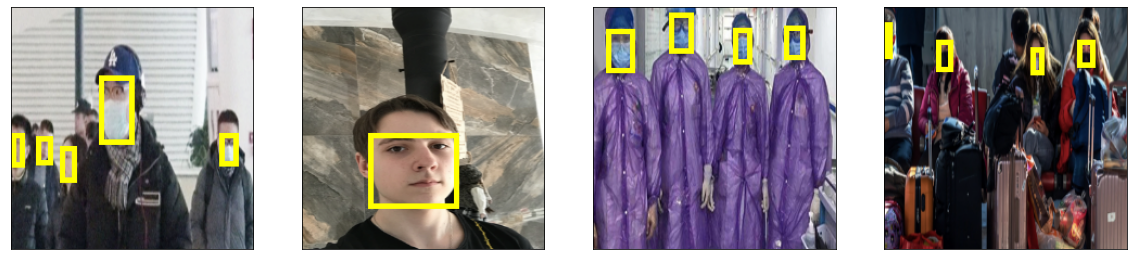

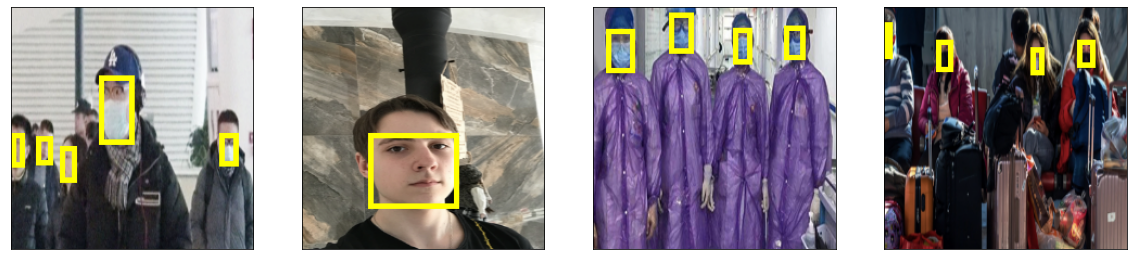

In [11]:
LABEL_MAP = {
    'with_mask': 2,
    'without_mask': 1,
    'mask_weared_incorrect': 3
}

revd=dict([reversed(i) for i in LABEL_MAP.items()])
LABEL_MAP.update(revd)


class MasksDataset(Dataset):
    def __init__(self, root, transforms, label_map):
        self.root = root
        self.transforms = transforms
        self.label_map = label_map
        self.images = list(sorted(os.listdir(os.path.join(root, 'images'))))
        self.annotations = list(sorted(os.listdir(os.path.join(root, 'annotations'))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.images[idx])
        ann_path = os.path.join(self.root, "annotations", self.annotations[idx])
        img = Image.open(img_path).convert("RGB")
        bboxes = []
        labels = []
        with open(ann_path, 'r') as f:
            tree = ET.parse(f)
            root = tree.getroot()
            size = root.find('size')
            w = int(size.find('width').text)
            h = int(size.find('height').text)

            for obj in root.iter('object'):
                difficult = obj.find('difficult').text
                if int(difficult) == 1:
                    continue
                cls_id = self.label_map[obj.find('name').text]
                xmlbox = obj.find('bndbox')
                b = [float(xmlbox.find('xmin').text), float(xmlbox.find('ymin').text),
                     min(float(xmlbox.find('xmax').text), w),
                     min(float(xmlbox.find('ymax').text), h)]
                bboxes.append(b)
                labels.append(cls_id)

        bboxes = torch.as_tensor(np.array(bboxes), dtype=torch.float32)
        labels = torch.as_tensor(np.array(labels), dtype=torch.int64)

        if self.transforms is not None:
            res = self.transforms(image=np.array(img), bboxes=bboxes, class_labels=labels)

        target = {
            'boxes': [torch.Tensor(x) for x in res['bboxes']],
            'labels': res['class_labels']
        }

        img = res['image']

        return img, target

    def __len__(self):
        return len(self.images)

def prepare(inp):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) * 255
    inp = inp.transpose((2,0,1))
    return torch.tensor(inp, dtype=torch.uint8)

class Masks(DetectionData):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def batch_to_images(self, batch):
        """
        Convert a batch of data to images in the expected format. The expected format is an iterable of cv2 images,
        where each image is a numpy array of shape (height, width, channels). The numbers in the array should be in the
        range [0, 255] in a uint8 format.
        """
        inp = torch.stack(list(batch[0])).cpu().detach().numpy().transpose((0, 2, 3, 1))
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        # Un-normalize the images
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        return inp * 255

    def batch_to_labels(self, batch):
        """
        Convert a batch of data to labels in the expected format. The expected format is a list of tensors of length N,
        where N is the number of samples. Each tensor element is in a shape of [B, 5], where B is the number of bboxes
        in the image, and each bounding box is in the structure of [class_id, x, y, w, h].
        """
        tensor_annotations = batch[1]
        label = []
        for annotation in tensor_annotations:
            if len(annotation["boxes"]):
                bbox = torch.stack(annotation["boxes"])
                # Convert the Pascal VOC xyxy format to xywh format
                bbox[:, 2:] = bbox[:, 2:] - bbox[:, :2]
                # The label shape is [class_id, x, y, w, h]
                label.append(
                    torch.cat([torch.stack(annotation["labels"]).reshape((-1, 1)), bbox], dim=1)
                )
            else:
                # If it's an empty image, we need to add an empty label
                label.append(torch.tensor([]))
        return label

    def infer_on_batch(self, batch, model, device):
        """
        Returns the predictions for a batch of data. The expected format is a list of tensors of shape length N, where N
        is the number of samples. Each tensor element is in a shape of [B, 6], where B is the number of bboxes in the
        predictions, and each bounding box is in the structure of [x, y, w, h, score, class_id].
        """
        nm_thrs = 0.2
        score_thrs = 0.5
        imgs = list(img.to(device) for img in batch[0])
        # Getting the predictions of the model on the batch
        with torch.no_grad():
            preds = model(imgs)
        processed_pred = []
        for pred in preds:
            # Performoing non-maximum suppression on the detections
            keep_boxes = torchvision.ops.nms(pred['boxes'], pred['scores'], nm_thrs)
            score_filter = pred['scores'][keep_boxes] > score_thrs

            # get the filtered result
            test_boxes = pred['boxes'][keep_boxes][score_filter].reshape((-1, 4))
            test_boxes[:, 2:] = test_boxes[:, 2:] - test_boxes[:, :2]  # xyxy to xywh
            test_labels = pred['labels'][keep_boxes][score_filter]
            test_scores = pred['scores'][keep_boxes][score_filter]

            processed_pred.append(
                torch.cat([test_boxes, test_scores.reshape((-1, 1)), test_labels.reshape((-1, 1))], dim=1))
        return processed_pred

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(20,20))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])




data_transforms = A.Compose([
    A.Resize(height=256, width=256),
    A.CenterCrop(height=224, width=224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

dataset = MasksDataset(root=os.path.join('./data'),
                        transforms=data_transforms,
                       label_map = LABEL_MAP)
train_set, val_set = torch.utils.data.random_split(dataset,
                                                    [int(len(dataset)*0.9), len(dataset)-int(len(dataset)*0.9)],
                                                    generator=torch.Generator().manual_seed(42))
val_set.transforms = A.Compose([ToTensorV2()])
train_loader = DataLoader(train_set, batch_size=8, collate_fn=(lambda batch: tuple(zip(*batch))))
val_loader = DataLoader(val_set, batch_size=8, collate_fn=(lambda batch: tuple(zip(*batch))))
data = next(iter(train_loader))
inp, targets = data[0][:4], data[1][:4]


result = [draw_bounding_boxes(prepare(inp[i]), torch.stack(targets[i]['boxes']),
                              colors=['yellow'] * torch.stack(targets[i]['boxes']).shape[0], width=5)
          for i in range(len(targets))]
show(result)

def prepare(inp):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) * 255
    inp = inp.transpose((2,0,1))
    return torch.tensor(inp, dtype=torch.uint8)

import torchvision.transforms.functional as F
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(20,20))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


data = next(iter(train_loader))
inp, targets = data[0][:4], data[1][:4]

result = [draw_bounding_boxes(prepare(inp[i]), torch.stack(targets[i]['boxes']),
                              colors=['yellow'] * torch.stack(targets[i]['boxes']).shape[0], width=5)
          for i in range(len(targets))]
show(result)

In [12]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 4)

In [7]:
# import the opencv library
import cv2

# define a video capture object
vid = cv2.VideoCapture(0)
  
while(True):
    ret, frame = vid.read()
    
    # print(type(frame), frame.shape)
    frame = cv2.resize(frame, (224, 224), interpolation=cv2.INTER_AREA)
    
    cv2.imshow('frame', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# After the loop release the cap object
vid.release()
# Destroy all the windows
cv2.destroyAllWindows()

In [21]:
def run_inference_for_single_image(model, image, live_cam):
    
    # convert image into numpy
    image = np.asarray(image)
    #print('Converted image into numpy type:', type(image))
    
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image)
    #print('Converted numpy into tensor format:', input_tensor)
    
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis,...]
    
    # Run inference
    if not live_cam:
        start_time = time.time()
        output_dict = model(input_tensor)
        end_time = time.time()
        print(f"Inference time: {np.ceil(end_time-start_time)} seconds per frame")

    output_dict = model(input_tensor)
    num_detections = int(output_dict.pop('num_detections')) # 300

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    
    output_dict = {key: value[0, :num_detections].numpy()
                   for key, value in output_dict.items()}
    
    output_dict['num_detections'] = num_detections

    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
    
    return output_dict

def showResult(img, target, label):
    result =  draw_bounding_boxes(prepare(img), torch.stack(target['boxes']),
                                labels=label,
                                colors=['red'], width=4)
    show(result)
    return

#showResult(data[0][1], data[1][1], ['No mask'])
_ = model.eval()
model(data[0][1])

ValueError: images is expected to be a list of 3d tensors of shape [C, H, W], got torch.Size([224, 224])

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 4)

_ = model.to(device)


params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)
num_epochs = 10
loss_list = []
for epoch in range(num_epochs):
    print('Starting training....{}/{}'.format(epoch + 1, num_epochs))
    loss_sub_list = []
    start = time.time()
    for images, targets in train_loader:
        filtered_images = []
        filtered_targets = []

        for image, t in zip(images, targets):
            if len(t['boxes']) > 0:
                filtered_images.append(image.to(device))
                filtered_targets.append({k: torch.stack(v).to(device) for k, v in t.items()})

        images = filtered_images
        targets = filtered_targets

        model.train()
        for target in targets:
            if len(target["boxes"]) != len(target["labels"]):
                print("Error: Different number of boxes and labels in {}".format(target["image_id"]))
                exit()

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        loss_sub_list.append(loss_value)

        # update optimizer and learning rate
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        # lr_scheduler.step()
    end = time.time()

    # print the loss of epoch
    epoch_loss = np.mean(loss_sub_list)
    loss_list.append(epoch_loss)
    print('Epoch {}/{} Loss: {:.4f} Time: {:.4f}'.format(epoch + 1, num_epochs, epoch_loss, end - start))

_ = model.eval()
batch = next(iter(train_loader))

print("Batch type is: ", type(batch))
print("First element is: ", type(batch[0]), "with len of ", len(batch[0]))
print("Example output of an image shape from the dataloader ", batch[0][0].shape)
print("Image values", batch[0][0])
print("-"*80)

print("Second element is: ", type(batch[1]), "with len of ", len(batch[1]))
print("Example output of a label shape from the dataloader ", batch[1][0])
training_data = Masks(data_loader=train_loader, label_map=LABEL_MAP)
val_data = Masks(data_loader=val_loader, label_map=LABEL_MAP)

training_data.validate_format(model, device)
val_data.validate_format(model, device)

# suite = full_suite()
# result = suite.run(training_data, val_data, model, device=device)
# result.save_as_html('my_suite.html')

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /home/koi/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:11<00:00, 14.2MB/s] 


Starting training....1/10
Epoch 1/10 Loss: 0.5391 Time: 3054.2407
Starting training....2/10
